# Image Recognition
Using the GDI image dataset, we set to develop a deep learning model to classify images with high performance.

**Using FastAI to develop a image classifer model**

In [1]:
from fastai.vision import Path, ImageDataBunch, get_transforms, cnn_learner, models, accuracy, error_rate

We first load in the data into a ImageDataBunch and visualize our mapping between the images and the labels. We also apply transforms on the data to increase our dataset size. We applied a 50-50 train-validation split to ensure our model generalizes well.

In [2]:
datapath = Path("../input/phacks/PatriotHack-master/images")
path = datapath.ls()

data = ImageDataBunch.from_folder(datapath, 
                                  train= datapath,
                                  valid_pct=0.5,
                                  test = None,
                                  ds_tfms=get_transforms(), size=224)

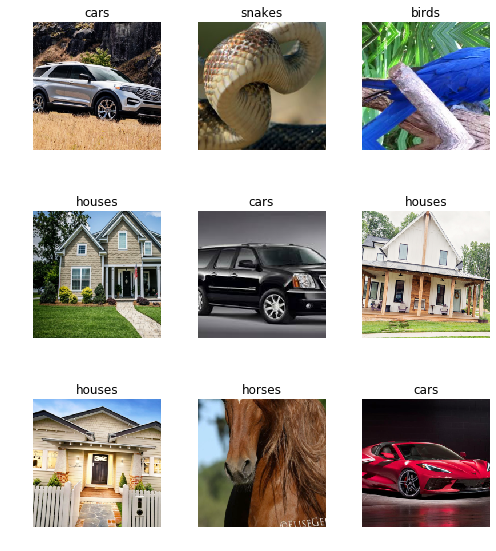

In [3]:
data.show_batch(rows=3, figsize=(7,8))

Then we called upon and trained a CNN model. We used a pretrained ResNet34 (on ImageNet) as our backbone.

In [4]:
learn = cnn_learner(data, models.resnet34,
                    metrics= [accuracy, error_rate], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 98.1MB/s]


Something we tried was to use learning rate finder to find our optimal learning rate but we realized that it took way too long to perform.

In [5]:
# learn.lr_find()
# learn.recorder.plot()

We then trained our model with one cycle policy, and applied weight decay to prevent overfitting. At this point,we are only training the head, not the pretrained parts. Then we applied a checkpoint to keep our model good.

In [6]:
learn.fit_one_cycle(5, wd=1e-3)
learn.save("stage-1")

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.788488,5.214272,0.131579,0.868421,00:10
1,3.646021,2.014432,0.385965,0.614035,00:10
2,2.854883,0.726320,0.745614,0.254386,00:09
3,2.205799,0.431099,0.859649,0.140351,00:09
4,1.781969,0.374180,0.894737,0.105263,00:10


Then we unfroze the model, training the pretrained body of the model. We applied a checkpoint after this as well.

In [7]:
learn.unfreeze()
learn.fit_one_cycle(3)
learn.save("stage-1")

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.289364,0.338859,0.903509,0.096491,00:09
1,0.236114,0.559640,0.885965,0.114035,00:09
2,0.202719,0.423610,0.894737,0.105263,00:10


We visualized what we got wrong and see what is happening.

In [8]:
from fastai.vision.learner import ClassificationInterpretation

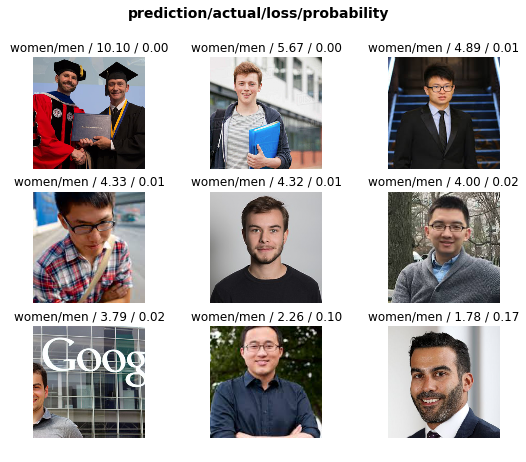

In [9]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_top_losses(9, figsize=(9,7))

When we reran the model on multiclass misclassification, we find that something else is wrong.

113 misclassified samples over 114 samples in the validation set.


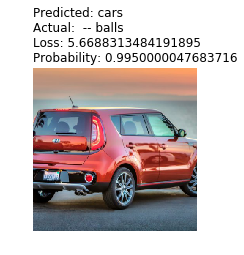

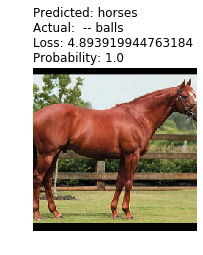

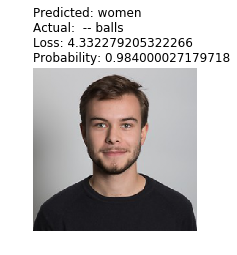

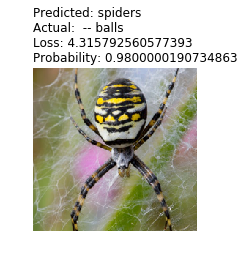

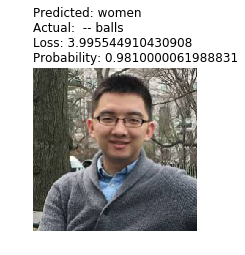

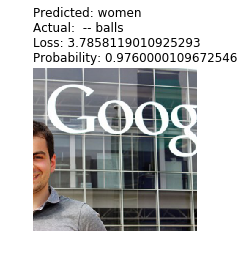

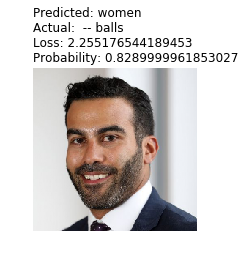

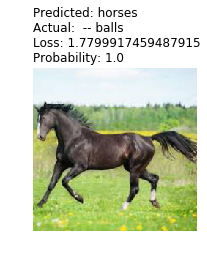

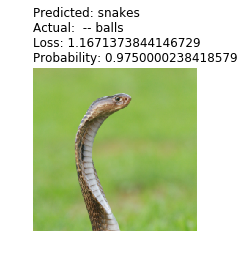

In [10]:
interp.plot_multi_top_losses(9, figsize=(3,3))

We then exported our model.

In [11]:
learn.path = Path("../working")
learn.export()

**We then wanted to make a PyTorch Model**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image as pImg
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from progressbar import progressbar
import time
import matplotlib.pyplot as plt

In [13]:
import os
classes = []
for c in path: classes.append(os.path.basename(c))

We had to preprocess the data first into torch Dataloaders.

In [14]:
x,y = [], []
for imgdir in path:
    for imgpath in imgdir.ls():
        x.append(torch.Tensor(np.array(pImg.open(imgpath).resize((224,224)))/255.0).transpose(0,2))
        y.append(os.path.basename(imgdir))

tx = torch.stack(x)
ty = torch.tensor(np.argmax(np.array(pd.get_dummies(pd.Series(y))), axis=1))

train_dl = DataLoader(TensorDataset(tx,ty), batch_size = 64)
valid_dl = DataLoader(TensorDataset(tx,ty), batch_size = 64)

We then made a classifer that had much of the backbone to train a model

In [15]:
class BasicTrainableClassifier(nn.Module):
    def __init__(self, crit:torch.nn.modules.loss=nn.CrossEntropyLoss(),
                 opt:torch.optim = torch.optim.Adam, rg = True):
        super().__init__()
        self.crit = crit
        self.opt = opt
        if repr(crit) == repr(nn.CrossEntropyLoss()): self.dtype = "long"
        else: self.dtype = "float"
        self.rg = rg 
        self.train_acc = []; self.valid_acc = []
        self.train_loss = []; self.valid_loss = []
    
    def localize(self, x:torch.Tensor, y=None):
        if torch.cuda.device_count():
            if not y: return x.cuda()
            return x.cuda().long() if y =="long" else x.cuda().float()
        if not y: return x
        return x.long() if y =="long" else x.float()

    def fit(self, train_ds:torch.utils.data.DataLoader,
            valid_ds:torch.utils.data.DataLoader=None,
            cbs:bool=False, epochs:int=1, learning_rate=1e-3):
        self.train()
        op = self.opt(self.parameters(), lr=learning_rate)
        for e in range(epochs):
            torch.cuda.empty_cache() if torch.cuda.device_count() else None
            for data in progressbar(train_ds):
                op.zero_grad()
                pred = self(self.localize(data[0]))
                loss = self.crit(pred, self.localize(data[1], self.dtype))
                loss.backward(retain_graph = self.rg)
                op.step()
            self.cbs_(e, train_ds, valid_ds=valid_ds) if cbs else None
  
    def acc(self, out, Y):
        return (torch.argmax(out, dim=1)==Y.long()).float().mean()
    
    def cbs_(self, e, train_ds:torch.utils.data.DataLoader,
             valid_ds:torch.utils.data.DataLoader=None):
        self.eval()
        train_acc, train_loss = 0,0
        valid_acc, valid_loss = 0,0
        for idx,data in enumerate(progressbar(train_ds)):
            train_pred = self(self.localize(data[0]))
            train_acc += self.acc(train_pred, self.localize(data[1], self.dtype)).item()
            train_loss += self.crit(train_pred, self.localize(data[1], self.dtype)).item()
        self.train_acc.append(train_acc/(idx+1)); self.train_loss.append(train_loss/(idx+1))
        for idx,data in enumerate(progressbar(valid_ds)):
            valid_pred = self(self.localize(data[0]))
            valid_acc += self.acc(valid_pred, self.localize(data[1], self.dtype)).item()
            valid_loss += self.crit(valid_pred, self.localize(data[1], self.dtype)).item()
        self.valid_acc.append(valid_acc/(idx+1)); self.valid_loss.append(valid_loss/(idx+1))
        time.sleep(1)
        print(f"Epoch {e+1}:")
        print(f'\tTrain Loss: {self.train_loss[-1]:.3f} | Train Acc: {self.train_acc[-1]*100:.2f}%')
        print(f'\t Val. Loss: {self.valid_loss[-1]:.3f} |  Val. Acc: {self.valid_acc[-1]*100:.2f}%')
        self.train()
        time.sleep(1)
    @property
    def plot(self):
        fig = plt.figure(figsize=(15,7.5), dpi= 80)
        plt.subplot(1, 2, 1)
        pltlen(self.valid_acc, label_ = "validation"), pltlen(self.train_acc, label_ = "training")
        plt.legend()
        plt.title(f"Accuracy: (V:{self.valid_acc[-1]}, T:{self.train_acc[-1]})")
        plt.subplot(1, 2, 2)
        pltlen(self.valid_loss, label_ = "validation"), pltlen(self.train_loss, label_ = "training")
        plt.legend()
        plt.title(f"Loss: (V:{self.valid_loss[-1]}, T:{self.train_loss[-1]})")
        plt.show()

def pltlen(x, label_=None): plt.plot(list(range(len(x))), x, label = label_)

Then we import the ResNet34 Model, but we tweak it so that it works for our case.

In [16]:
from fastai.vision import models
class noop(nn.Module):
    def __init__(self): super().__init__()
    def __call__(self, x): return x
class ResNet34(BasicTrainableClassifier):
    def __init__(self):
        super().__init__()
        res = models.resnet34(pretrained=True)
        res.fc = nn.Linear(512, 9)
        self.model = nn.Sequential(res, nn.Softmax())
    def forward(self,x): return self.model(x)

In [17]:
model = ResNet34().cuda()

In [18]:
model

ResNet34(
  (crit): CrossEntropyLoss()
  (model): Sequential(
    (0): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [19]:
model.fit(train_dl, valid_dl, epochs=20, cbs=True)

N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:

Epoch 1:
	Train Loss: 2.224 | Train Acc: 12.89%
	 Val. Loss: 2.224 |  Val. Acc: 12.89%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 2:
	Train Loss: 2.226 | Train Acc: 14.45%
	 Val. Loss: 2.226 |  Val. Acc: 14.45%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 3:
	Train Loss: 2.153 | Train Acc: 21.88%
	 Val. Loss: 2.153 |  Val. Acc: 21.88%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 4:
	Train Loss: 2.228 | Train Acc: 12.11%
	 Val. Loss: 2.228 |  Val. Acc: 12.11%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 5:
	Train Loss: 2.200 | Train Acc: 17.19%
	 Val. Loss: 2.200 |  Val. Acc: 17.19%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 6:
	Train Loss: 1.989 | Train Acc: 37.11%
	 Val. Loss: 1.989 |  Val. Acc: 37.11%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 7:
	Train Loss: 2.009 | Train Acc: 36.33%
	 Val. Loss: 2.009 |  Val. Acc: 36.33%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 8:
	Train Loss: 2.096 | Train Acc: 26.69%
	 Val. Loss: 2.096 |  Val. Acc: 26.69%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 9:
	Train Loss: 1.901 | Train Acc: 50.04%
	 Val. Loss: 1.901 |  Val. Acc: 50.04%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 10:
	Train Loss: 1.891 | Train Acc: 50.35%
	 Val. Loss: 1.891 |  Val. Acc: 50.35%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 11:
	Train Loss: 1.769 | Train Acc: 64.37%
	 Val. Loss: 1.769 |  Val. Acc: 64.37%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 12:
	Train Loss: 1.772 | Train Acc: 64.06%
	 Val. Loss: 1.772 |  Val. Acc: 64.06%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 13:
	Train Loss: 1.728 | Train Acc: 66.58%
	 Val. Loss: 1.728 |  Val. Acc: 66.58%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 14:
	Train Loss: 1.839 | Train Acc: 54.77%
	 Val. Loss: 1.839 |  Val. Acc: 54.77%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 15:
	Train Loss: 1.814 | Train Acc: 57.64%
	 Val. Loss: 1.814 |  Val. Acc: 57.64%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 16:
	Train Loss: 1.698 | Train Acc: 71.35%
	 Val. Loss: 1.698 |  Val. Acc: 71.35%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 17:
	Train Loss: 1.626 | Train Acc: 80.73%
	 Val. Loss: 1.626 |  Val. Acc: 80.73%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 18:
	Train Loss: 1.594 | Train Acc: 83.85%
	 Val. Loss: 1.594 |  Val. Acc: 83.85%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 19:
	Train Loss: 1.582 | Train Acc: 84.64%
	 Val. Loss: 1.582 |  Val. Acc: 84.64%


N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (3 of 4) |###################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (1 of 4) |######                    | Elapsed Time: 0:00:00 ETA:  00:00:00
 50% (2 of 4) |#############            

Epoch 20:
	Train Loss: 1.565 | Train Acc: 85.42%
	 Val. Loss: 1.565 |  Val. Acc: 85.42%


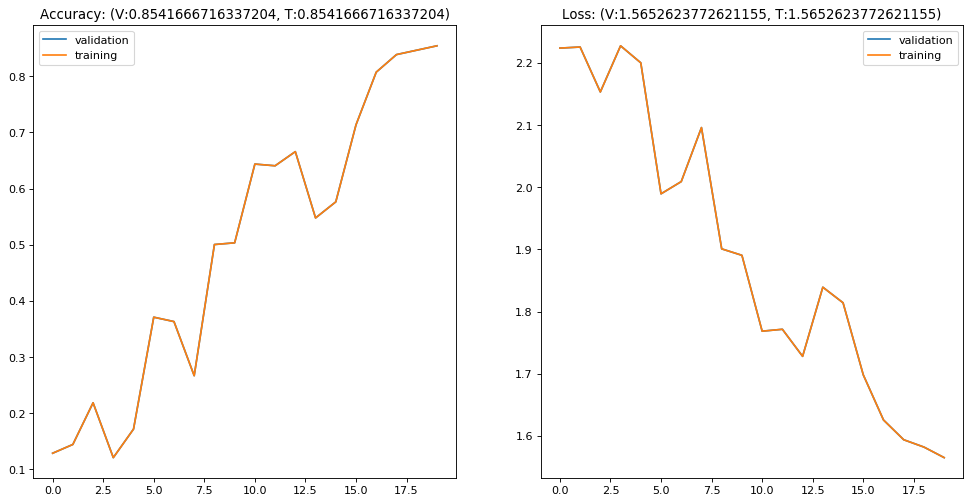

In [20]:
model.plot

In [21]:
import pickle
with open("../working/torch_model.pkl", 'wb') as pf:
    pickle.dump(model, pf)

In [22]:
# data = ImageDataBunch.from_folder(datapath, 
#                                   train= datapath,
#                                   valid_pct=0.6,
#                                   test = datapath,
#                                   ds_tfms=get_transforms(), size=224)

In [23]:
# data.show_batch(rows=3, figsize=(7,8))

In [24]:
# learn = cnn_learner(data, models.resnet34, metrics= [accuracy, error_rate], model_dir="/tmp/model/")

In [25]:
# learn.lr_find()
# learn.recorder.plot()

In [26]:
# learn.fit_one_cycle(5, wd=1e-1)

In [27]:
# learn.save("stage-1")

In [28]:
# learn.unfreeze()
# learn.fit_one_cycle(1)
# learn.save("stage-2")

In [29]:
# learn.path = Path("../working")
# learn.export()

In [30]:
# from fastai.basic_train import load_learner
# model = load_learner("../working")

In [31]:
# datapath.ls()[4].ls()[0]

In [32]:
# from PIL import Image as pImg

# path = str(datapath.ls()[4].ls()[0])
# img = np.array(pImg.open(path).resize((224,224)))

# print(path,torch.argmax(smodel(torch.from_numpy(img).transpose(0,2).float().unsqueeze(0).cuda())), sep="\n")

In [33]:
# learn.fit_one_cycle(1)

In [34]:
# learn.lr_find()
# learn.recorder.plot()

In [35]:
# import time
# import matplotlib.pyplot as plt
# from IPython.display import clear_output

# for x,y in dl:
#     for img, label in zip(x,y):
#         p = learn.model.forward(img.unsqueeze(0).cuda()).cpu().detach().numpy()
#         plt.imshow(img.transpose(0,2).transpose(0,1).numpy())
#         plt.title(f'''Actual:{classes[label.unsqueeze(0).numpy()[0]]} :: Pred: {classes[np.argmax(p)]}''')
#         plt.show()
#         time.sleep(0.5)
#         plt.close()
#         clear_output(wait=True)

In [36]:
# import pickle
# with open("../working/model.pkl", 'wb') as pf:
#     pickle.dump(learn.model, pf)

In [37]:
# learn.path = Path("../working")
# learn.export()

In [38]:
# # !pip install google_images_download
# from google_images_download import google_images_download

# def scrapeImages(topic:str, limit:int=10,
#                  dirout:str="../working/data")->None:
    
#     response = google_images_download.googleimagesdownload()
#     config = {"keywords":topic, "limit" : limit, "format" : "jpg",
#               "output_directory" : dirout,
#               "image_directory": topic,"no_numbering" : True}
    
#     response.download(config)

# for c in classes: scrapeImages(c, limit=2)
# # import matplotlib.pyplot as plt
# # import cv2
# # from IPython.display import clear_output
# # import time

# # downloads = Path("../output/bird").ls()
# # for dp in downloads[:25]:
# #     img = cv2.resize(cv2.imread(str(dp)), (224,224))/255
# #     plt.imshow(img)
# #     plt.show()
# #     time.sleep(1)
# #     clear_output(True)

In [39]:
# ddatapath = Path("../working/data")
# dirs = ddatapath.ls()

In [40]:
# import glob, os
# import re

# ndatapath = Path("../input/phacksscraped/data")
# npath = ndatapath.ls()

# for i in npath:
#     for x,img in enumerate(i.ls()):
#         ss = ".".join((os.path.basename(img)).split(".")[-2:])
#         print(os.path.join(
#             os.path.abspath(
#                 os.path.join(os.path.dirname(img),"..")),".".join(
#                 (os.path.basename(img)+str(x)).split(".")[-2:])))

In [41]:
# from IPython.display import FileLink
# import shutil
# shutil.make_archive("../working/data1", 'zip', "../working/data")

In [42]:
# os.path.join(
#             os.path.abspath(
#                 os.path.join(os.path.dirname(img),"..")),".".join(
#                 (os.path.basename(img)+str(x)).split(".")[-2:]))

In [43]:
# from PIL import Image
# import os
# from tqdm import tqdm
# c=1
# for topic in tqdm(search):
#     for img in topic.ls():
#         print(img)
#         im = Image.open(img)
#         name= os.path.basename(img)+str(c)+'.jpg'
#         rgb_im = im.convert('RGB')
#         rgb_im.save(name)
#         c+=1

In [44]:
# new_data = ImageDataBunch.from_folder(ndatapath,
#                                       train= ndatapath,
#                                       valid_pct=0.2,
#                                       test = None,
#                                       classes = classes, size=224).normalize(imagenet_stats)

In [45]:
# learn.data = new_data

In [46]:
# learn.fit_one_cycle(3)

In [47]:
# import matplotlib.pyplot as plt
# import cv2
# from IPython.display import clear_output
# import time

# downloads = Path("../output/horses").ls()
# for dp in downloads[:25]:
#     img = cv2.resize(cv2.imread(str(dp)), (224,224))/255
#     plt.imshow(img)
#     plt.show()
#     time.sleep(1)
#     clear_output(True)